In [183]:
import os
import json

import h5py

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.ndimage import uniform_filter1d

from deephyper.skopt.learning import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import r2_score

In [2]:
# dataset = "fcnet_naval_propulsion_data"
# dataset = "fcnet_parkinsons_telemonitoring_data"
# dataset = "fcnet_protein_structure_data"
dataset = "fcnet_slice_localization_data"
path = "/Users/romainegele/Documents/Argonne/deephyper-benchmark/lib/HPOBench/tabular/build/HPOBench/data/fcnet_tabular_benchmarks"
path = os.path.join(path, f"{dataset}.hdf5")

In [3]:
f = h5py.File(path, "r")

In [4]:
num_elements = len(f.keys())
print(f"{num_elements=}")

num_elements=62208


In [5]:
for k in f.keys():
    print(k)
    print(type(k))
    break

{"activation_fn_1": "relu", "activation_fn_2": "relu", "batch_size": 16, "dropout_1": 0.0, "dropout_2": 0.0, "init_lr": 0.0005, "lr_schedule": "const", "n_units_1": 128, "n_units_2": 128}
<class 'str'>


In [6]:
f[k].keys()

<KeysViewHDF5 ['final_test_error', 'n_params', 'runtime', 'train_loss', 'train_mse', 'valid_loss', 'valid_mse']>

In [7]:
f[k]["valid_loss"][0]

array([0.01920455, 0.0096807 , 0.00744378, 0.01585275, 0.00617106,
       0.00439411, 0.00305224, 0.0030084 , 0.00377812, 0.00454525,
       0.00227072, 0.00218144, 0.00164852, 0.00194886, 0.00246745,
       0.00176901, 0.00163817, 0.00143865, 0.00151026, 0.00166684,
       0.0019256 , 0.00141233, 0.00126494, 0.00124106, 0.00132713,
       0.00109414, 0.00110013, 0.00120906, 0.00108367, 0.00111928,
       0.0010585 , 0.00113214, 0.00101101, 0.00100692, 0.00108707,
       0.00108335, 0.00096453, 0.0009712 , 0.00123987, 0.00092371,
       0.00096755, 0.00100982, 0.00104   , 0.00108536, 0.00099426,
       0.00085271, 0.00101104, 0.00130683, 0.00078464, 0.00088596,
       0.00078992, 0.00084402, 0.00084882, 0.00082267, 0.00087057,
       0.00084512, 0.00085869, 0.00095976, 0.00099259, 0.0012128 ,
       0.00079094, 0.00095768, 0.00091932, 0.00090248, 0.00085119,
       0.00115939, 0.00103418, 0.00087807, 0.00075717, 0.00082636,
       0.00091596, 0.0007469 , 0.00083445, 0.00095413, 0.00084

In [200]:
# Collect Hyperparamerter Names
hp_names = None
for k in f.keys():
    d = json.loads(k)
    hp_names = [hp_name for hp_name in d]
    break
print(f"{hp_names=}")

# Collect values of hyperparmaters and learning curve for each config
configurations = []
learning_curves = []
for k in f.keys():
    d = json.loads(k)
    
    config = [d[hp_name] for hp_name in hp_names]
    configurations.append(config)
    
    curve = f[k]["valid_loss"][0] # select curve 0 out of 4
    
    # make monotonic
    curve = pd.Series(curve).cummin().tolist()
    
    # smooth the curve
    curve = uniform_filter1d(curve, size=5)
    
    learning_curves.append(curve)

hp_names=['activation_fn_1', 'activation_fn_2', 'batch_size', 'dropout_1', 'dropout_2', 'init_lr', 'lr_schedule', 'n_units_1', 'n_units_2']


In [201]:
print(len(configurations))
print(len(learning_curves))

62208
62208


## Fitting the Random-Forest Model

In [202]:
seed = 42
rs = np.random.RandomState(seed)
test_ratio = 0.33

indexes = np.arange(len(configurations))
rs.shuffle(indexes) # Performed in place
isplit = int((1-test_ratio) * len(configurations))

train_indexes = indexes[:isplit]
test_indexes = indexes[isplit:]

train_data = ([configurations[i] for i in train_indexes], [learning_curves[i] for i in train_indexes])
test_data = ([configurations[i] for i in test_indexes], [learning_curves[i] for i in test_indexes])

In [203]:
# strategy 1: budget as input
def build_dataset_1(data):
    X, y = [], []
    for config, curve in zip(*train_data):
        for i, perf in enumerate(curve):

            xi = config + [i]
            yi = perf

            X.append(xi)
            y.append(yi)

    X, y = np.asarray(X, dtype="O"), np.asarray(y)
    
    return X, y

In [204]:
# strategy 2: predict the learning curve
def build_dataset_2(data):
    X = np.asarray(data[0], dtype="O")
    y = np.asarray(data[1])
    return X, y

In [205]:
# Preprocessing
def apply_preprocessing(X, y):

    # labels to integer
    categorical_indexes = [i for i, v in enumerate(X[0].tolist()) if type(v) is str]

    print("before: ", X[0])
    for i in categorical_indexes:
        X[:, i] = LabelEncoder().fit_transform(X[:, i])
    print("after: ", X[0])

    X = X.astype(float)

    # apply log on target
    # y = MinMaxScaler(feature_range=(1e-6, 1), clip=True).fit_transform(y.reshape(-1, 1)).reshape(-1)
    y_max = y.max()
    # y = y / y_max
    y = np.log(y)/np.log(y_max)
    
    print(f"{X.shape=}")
    print(f"{y.shape=}")
    
    return X, y

In [223]:
# test strategy 1

k = 100 # number of configurations used to train
b = 100
N = k * b # indexes to keep for training
print(f"trained on data up to {N}")

X, y = build_dataset_1(train_data)
X, y = apply_preprocessing(X, y)

est = RandomForestRegressor(n_jobs=8)
est.fit(X[:N], y[:N])

r2_train = est.score(X[:N], y[:N])
print(f"{r2_train=:.3f}")

r2_test = est.score(X[N:], y[N:])
print(f"{r2_test=:.3f}")

# for maximum budget
y_true_b_max = y[N+b::b].reshape(-1)
y_pred_b_max = est.predict(X[N+b::b]).reshape(-1)

r2_test_b_max = r2_score(y_true_b_max, y_pred_b_max)
print(f"{r2_test_b_max=:.3f}")

print(spearmanr(y_true_b_max, y_pred_b_max))

trained on data up to 10000
before:  ['tanh' 'relu' 16 0.3 0.3 0.001 'const' 128 512 0]
after:  [1 0 16 0.3 0.3 0.001 0 128 512 0]
X.shape=(4167900, 10)
y.shape=(4167900,)
r2_train=1.000
r2_test=0.767
r2_test_b_max=0.633
SpearmanrResult(correlation=0.8349482838857781, pvalue=0.0)


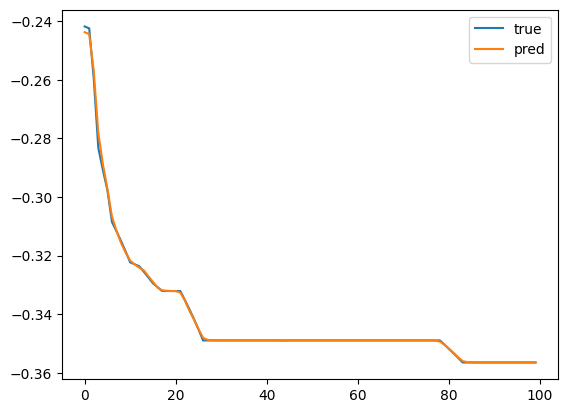

In [207]:
iconfig = 0
offset = iconfig * b
configs = [X[offset+i] for i in range(b)]
y_true = [y[offset+i] for i in range(b)]

y_pred = est.predict(configs)

plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")
plt.legend()
plt.show()

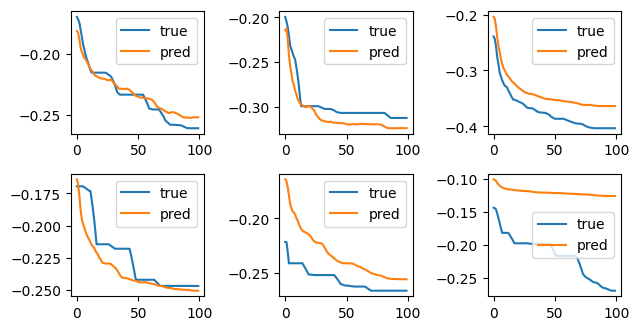

In [208]:
iconfig_start = 12_100
num_display = 6 # must be divisible by 2
plt.figure()
for i, iconfig in enumerate(range(iconfig_start, iconfig_start+num_display)):
    offset = iconfig * b
    configs = [X[offset+i] for i in range(b)]
    y_true = [y[offset+i] for i in range(b)]

    y_pred = est.predict(configs)

    plt.subplot(num_display//2, num_display//2, i+1)
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="pred")
    plt.legend()
plt.tight_layout()
plt.show()

In [220]:
# test strategy 2

k = 100 # number of configurations used to train
b = 100
N = k * b # indexes to keep for training

X, y = build_dataset_2(train_data)
X, y = apply_preprocessing(X, y)

est = RandomForestRegressor(n_jobs=8)
est.fit(X[:k], y[:k])

r2_train = est.score(X[:k], y[:k])
print(f"{r2_train=:.3f}")

r2_test = est.score(X[k:], y[k:])
print(f"{r2_test=:.3f}")

# for maximum budget
y_true_b_max = y.reshape(-1)[k+b::b]
y_pred_b_max = est.predict(X).reshape(-1)[k+b::b]

r2_test_b_max = r2_score(y_true_b_max, y_pred_b_max)
print(f"{r2_test_b_max=:.3f}")

print(spearmanr(y_true_b_max, y_pred_b_max))

before:  ['tanh' 'relu' 16 0.3 0.3 0.001 'const' 128 512]
after:  [1 0 16 0.3 0.3 0.001 0 128 512]
X.shape=(41679, 9)
y.shape=(41679, 100)
r2_train=0.974
r2_test=0.812
r2_test_b_max=0.697
SpearmanrResult(correlation=0.873260144629597, pvalue=0.0)


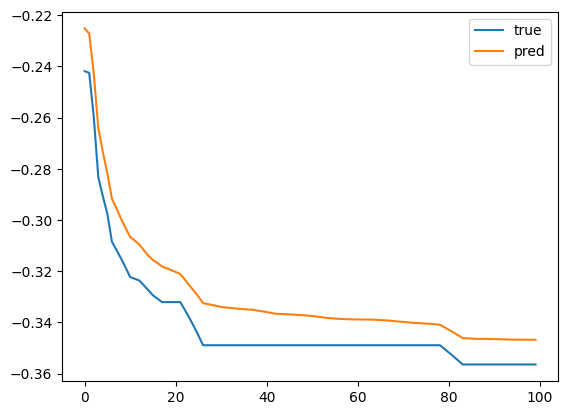

In [216]:
iconfig = 0
configs = [X[iconfig]]
y_true = y[iconfig]

y_pred = est.predict(configs)[0]

plt.figure()
plt.plot(y_true, label="true")
plt.plot(y_pred, label="pred")
plt.legend()
plt.show()

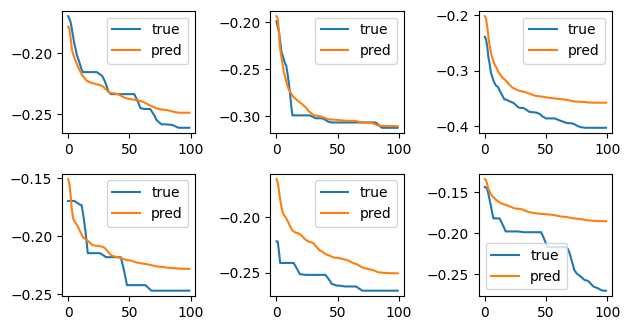

In [217]:
iconfig_start = 12_100
num_display = 6 # must be divisible by 2
plt.figure()
for i, iconfig in enumerate(range(iconfig_start, iconfig_start+num_display)):
    configs = [X[iconfig]]
    y_true = y[iconfig]

    y_pred = est.predict(configs)[0]

    plt.subplot(num_display//2, num_display//2, i+1)
    plt.plot(y_true, label="true")
    plt.plot(y_pred, label="pred")
    plt.legend()
plt.tight_layout()
plt.show()

In [224]:
# https://github.com/JoaquinAmatRodrigo/skforecast/
# https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
# with exogenous variables

<div class="alert alert-block alert-warning">
In the previous cells, each curve of the training set is fit on all observations (budget of 100 steps). However, in practice the models can be pruned, and therefore we should test on fitting on different curves with various number of steps. Also we will have an imbalance.
</div>

https://www.ibm.com/docs/en/watson-studio-local/1.2.3?topic=notebooks-markdown-jupyter-cheatsheet

## Fitting the Inverse Power-Law Model